In [1]:
import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from HOSim.solver import rk4_step, f

import numpy as np
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

In [6]:
modes = 64
mHOS = 8
tMax = 200
step_size = 0.025
output_interval = 5
harmonics = 8

A = 0.1
k = 1
Ta = 8*2*np.pi
g = 9.81

eta_hat_0 = np.zeros(modes+1, dtype=complex)
phi_hat_0 = np.zeros(modes+1, dtype=complex)

eta_hat_0[1] = A * modes
phi_hat_0[1] = -1.j * A * np.sqrt(g/k) * modes

y = np.concatenate((eta_hat_0, phi_hat_0))
k0 = 1

steps = int(np.ceil(tMax / step_size))

f_jit = jax.jit(f, static_argnums=(2, 3, 4, 5, 6))
rk4_step_jit = jax.jit(rk4_step, static_argnums=(2, 3, 4, 5, 6, 7, 8))

result = np.zeros((int(np.floor(steps / output_interval))+1, harmonics), dtype=complex)

t = 0
for i in range(steps):
    if i % output_interval == 0:
        result[i // output_interval] = y[1:harmonics+1]

    y = rk4_step_jit(t, y, step_size, modes, g, k0, mHOS, Ta, f_jit)
    t += step_size

result[-1] = y[1:harmonics+1]

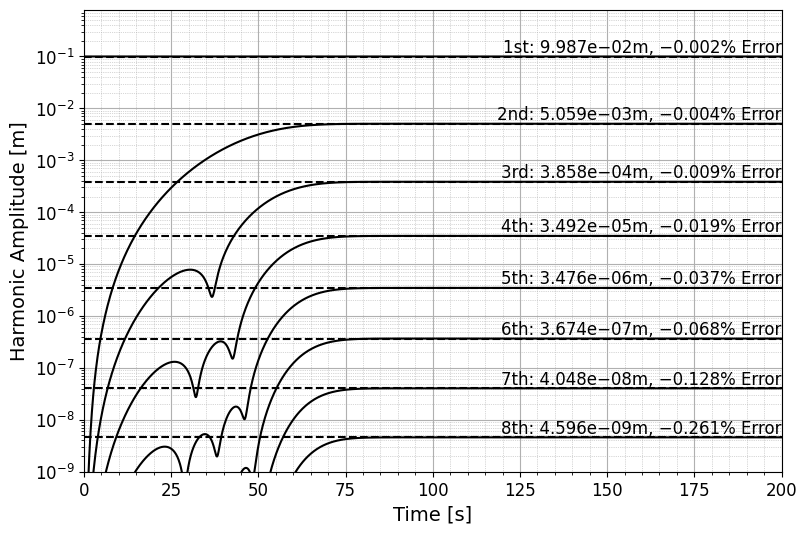

In [10]:
def ordinal(n):
    if 10 <= n % 100 <= 20:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return f"{n}{suffix}"

fontsize = 12

amps = np.array([9.9870520E-02, 5.0594125E-03, 3.8584235E-04, 3.4929691E-05, 3.4769679E-06, 3.6763951E-07, 4.0531740E-08, 4.6076934E-09])

fig, ax = plt.subplots(figsize=(9, 6))
for i in range(harmonics):
    modal_result = abs(result[-1, i]) / modes
    modal_error = (modal_result - amps[i]) / modal_result * 100
    plt.semilogy(np.linspace(0, tMax, result.shape[0]), abs(result[:, i]) / modes, color="k", label=f"Harmonic {i+1}: {modal_result:.3e}m, {modal_error:.3f}% Error")
    plt.axhline(y=amps[i], color="k", linestyle="--")
    ax.annotate(f"{ordinal(i+1)}: {modal_result:.3e}m, {modal_error:+1.3f}% Error".replace("-", "−"),
                xy=(tMax, modal_result),         # Point to annotate
                xytext=(tMax, modal_result),     # Text location
                # arrowprops=dict(arrowstyle='-'),
                va='bottom',
                ha='right',
                fontsize=fontsize)

plt.xlim(0, tMax)
plt.ylim(10.0E-10)
plt.ylabel("Harmonic Amplitude [m]", fontsize=fontsize+2)
plt.xlabel("Time [s]", fontsize=fontsize+2)
ax.grid(True, which='major', linewidth=0.8)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth=0.5)
ax.tick_params(labelsize=12)
plt.savefig("results/verification_1d.pdf", dpi=300, bbox_inches='tight')
plt.show()